# Link prediction with Metapath2Vec

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/metapath2vec-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/metapath2vec-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

## Introduction

This demo notebook demonstrates how to predict friendship links/edges between users in the Blog Catalog dataset using Metapath2Vec. Metapath2Vec is a useful algorithm that allows us to run random walks on a heterogeneous graph (with multiple node types) by defining "metapaths" which tell the algorithm how to traverse the different node types that exist in the graph.

Using Metapath2Vec, we're going to tackle link prediction as a supervised learning problem on top of node representations/embeddings. After obtaining embeddings via the unsupervised algorithm, a binary classifier can be used to predict a link, or not, between any two nodes in the graph. Various hyperparameters could be relevant in obtaining the best link classifier - this demo demonstrates incorporating model selection into the pipeline for choosing the best binary operator to apply on a pair of node embeddings.

There are four steps:

1. Obtain embeddings for each node
2. For each set of hyperparameters, train a classifier
3. Select the classifier that performs the best
4. Evaluate the selected classifier on unseen data to validate its ability to generalise

> StellarGraph supports other algorithms for doing [link prediction](README.md), as well as many [other tasks](../README.md) such as [node classification](../node-classification/README.md), and [representation learning](../embeddings/README.md).

### References

[1] Metapath2Vec: Scalable Representation Learning for Heterogeneous Networks. Y. Dong, N. Chawla, A. Swami, ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2017.

[2] Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. 

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

## Load the dataset

The Blog Catalog 3 dataset is a heterogeneous network with two different node types - `user` and `group`. Two `user` nodes can be connected via a `friend` edge type (i.e. two users are friends), and a `user` can also be connected to a `group` via a `belongs` edge type (i.e. user belongs to group). 

In [4]:
dataset = datasets.BlogCatalog3()
display(HTML(dataset.description))
graph = dataset.load()

In [5]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 10351, Edges: 348459

 Node types:
  user: [10312]
    Features: none
    Edge types: user-belongs->group, user-friend->user
  group: [39]
    Features: none
    Edge types: group-belongs->user

 Edge types:
    user-friend->user: [333983]
        Weights: all 1 (default)
        Features: none
    user-belongs->group: [14476]
        Weights: all 1 (default)
        Features: none


## Construct splits of the input data

We have to carefully split the data to avoid data leakage and evaluate the algorithms correctly:

* For computing node embeddings, a **Train Graph** (`graph_train`)
* For training classifiers, a classifier **Training Set** (`examples_train`) of positive and negative edges that weren't used for computing node embeddings
* For choosing the best classifier, an **Model Selection Test Set** (`examples_model_selection`) of positive and negative edges that weren't used for computing node embeddings or training the classifier 
* For the final evaluation, a **Test Graph** (`graph_test`) to compute test node embeddings with more edges than the Train Graph, and a **Test Set** (`examples_test`) of positive and negative edges not used for neither computing the test node embeddings or for classifier training or model selection

###  Test Graph

We begin with the full graph and use the `EdgeSplitter` class to produce:

* Test Graph
* Test set of positive/negative link examples

The Test Graph is the reduced graph we obtain from removing the test set of links from the full graph.

In [6]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", edge_label="friend"
)

print(graph_test.info())

Network has 333983 edges of type friend
Network has 333983 edges of type friend
** Sampled 33398 positive and 33398 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 10351, Edges: 315061

 Node types:
  user: [10312]
    Features: none
    Edge types: user-belongs->group, user-friend->user
  group: [39]
    Features: none
    Edge types: group-belongs->user

 Edge types:
    user-friend->user: [300585]
        Weights: all 1 (default)
        Features: none
    group-belongs->user: [14476]
        Weights: all 1 (default)
        Features: none


### Train Graph

This time, we use the `EdgeSplitter` on the Test Graph, and perform a train/test split on the examples to produce:

* Train Graph
* Training set of link examples
* Set of link examples for model selection


In [7]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global", edge_label="friend"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

Network has 300585 edges of type friend
Network has 300585 edges of type friend
** Sampled 30058 positive and 30058 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 10351, Edges: 285003

 Node types:
  user: [10312]
    Features: none
    Edge types: user-belongs->group, user-friend->user
  group: [39]
    Features: none
    Edge types: group-belongs->user

 Edge types:
    user-friend->user: [270527]
        Weights: all 1 (default)
        Features: none
    group-belongs->user: [14476]
        Weights: all 1 (default)
        Features: none


Below is a summary of the different splits that have been created in this section

In [8]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,45087,Train Graph,Test Graph,Train the Link Classifier
Model Selection,15029,Train Graph,Test Graph,Select the best Link Classifier model
Test set,66796,Test Graph,Full Graph,Evaluate the best Link Classifier


## Metapath2Vec

We use Metapath2Vec [1], to calculate node embeddings. These embeddings are learned in such a way to ensure that nodes that are close in the graph remain close in the embedding space. Similar to Node2Vec [2], we first run random walks which are used to generate context pairs, and these are fed into a Word2Vec model to generate embeddings.

The random walks in Metapath2Vec are driven by a set of metapaths that define the node type order by which the random walk explores the graph. For example, a metapath like `["user", "group", "user"]` can be interpreted as a rule for the random walk to always traverse the graph starting from a `user` node -> `group` node -> `user` node. Some things to keep in mind when defining metapaths are:

* Each metapath must begin and end on the same node type, which must be the node type that you intend to obtain embeddings for. 
* When `walk_length` is greater than the length of a metapath, the metapath is automatically repeated to fill the length of the walk.
* The graph should have edge types that connect two adjacent nodes in a metapath. For example, for Blog Catalog 3, there aren't any edge types connecting two `group` nodes, so `["group, "group"]` will not be a useful metapath.

These are the set of parameters we can use:

* `dimensions` - Dimensionality of node2vec embeddings
* `num_walks` - Number of walks from each node
* `walk_length` - Length of each random walk
* `context_window_size` - Context window size for Word2Vec
* `num_iter` - number of SGD iterations (epochs)
* `workers` - Number of workers for Word2Vec
* `user_metapaths` - A list of metapaths for the random walks to traverse in the graph.

In [9]:
dimensions = 128
num_walks = 1
walk_length = 100
context_window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()
user_metapaths = [
    ["user", "group", "user"],
    ["user", "group", "user", "user"],
    ["user", "user"],
]

In [10]:
from stellargraph.data import UniformRandomMetaPathWalk
from gensim.models import Word2Vec


def metapath2vec_embedding(graph, name):
    rw = UniformRandomMetaPathWalk(graph)
    walks = rw.run(
        graph.nodes(), n=num_walks, length=walk_length, metapaths=user_metapaths
    )
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        size=dimensions,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=workers,
        iter=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [11]:
embedding_train = metapath2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 30936


## Train and evaluate the link prediction model

There are a few steps involved in using the Word2Vec model to perform link prediction:
1. We calculate link/edge embeddings for the positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes of each sampled edge.
2. Given the embeddings of the positive and negative examples, we train a logistic regression classifier to predict a binary value indicating whether an edge between two nodes should exist or not.
3. We evaluate the performance of the link classifier for each of the 4 operators on the training data with node embeddings calculated on the **Train Graph** (`graph_train`), and select the best classifier.
4. The best classifier is then used to calculate scores on the test data with node embeddings calculated on the **Test Graph** (`graph_test`).

Below are a set of helper functions that let us repeat these steps for each of the binary operators.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

We consider 2 different operators: 

* $L_1$
* $L_2$

The Node2Vec paper [2] provides a detailed description of these operators. All operators produce link embeddings that have equal dimensionality to the input node embeddings (128 dimensions for our example). 

Note that the `hadamard` and `average` operators from the reference paper has been omitted from this demo, since they aren't able to handle the case where two different sets of embeddings (`train` and `test`) have been calculated independently. With two different sets of embeddings, we want the operator to calculate some sort of relationship between a pair of embeddings rather than draw meaning from their specific values, so these two operators are not well suited for this situation.

In [13]:
def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_l1, operator_l2]

In [14]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


,ROC AUC score
name,
operator_l1,0.826110
operator_l2,0.831046


### Evaluate the best model using the test set

Now that we've trained and selected our best model, we use a test set of embeddings and calculate a final evaluation score.

In [15]:
embedding_test = metapath2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 30936


In [16]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.7389910535953208


### Visualise representations of link embeddings

Learned link embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions using the PCA algorithm ([link](https://en.wikipedia.org/wiki/Principal_component_analysis)). 

Blue points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

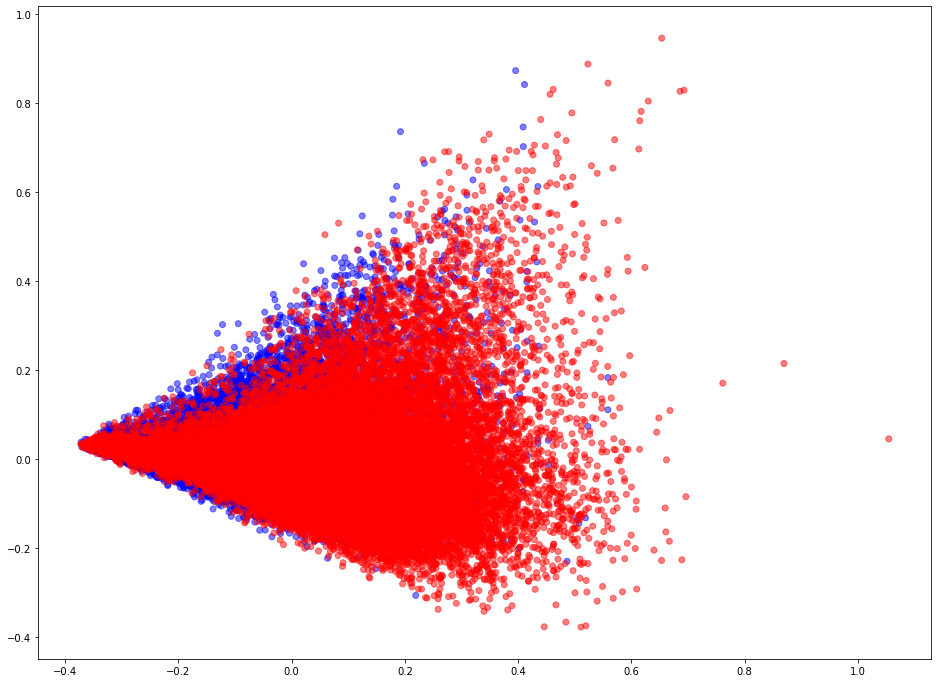

In [17]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

## Conclusion

This example has demonstrated how to use the `stellargraph` library to apply a link prediction algorithm for heterogeneous graphs using the Metapath2Vec [1] representation learning algorithm.

This notebook ran through the following steps:

1. Obtained embeddings for each node
2. Trained a classifier for each set of hyperparameters
3. Selected the classifier that performed best
4. Evaluated the selected classifier on unseen data to validate its ability to generalise

StellarGraph includes [other algorithms for link prediction](README.md) and [algorithms and demos for other tasks](../README.md).

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/metapath2vec-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/metapath2vec-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>